# Introduction to data analysis using machine learning #

## 02. Clustering with K-Means ##

by David Taylor, [www.prooffreader.com](http://www.prooffreader.com) (blog) [www.dtdata.io](http://dtdata.io) (hire me!)

For links to more material including a slideshow explaining all this stuff in further detail, please see the front page of [this GitHub repo.](https://github.com/Prooffreader/intro_machine_learning)

This is notebook 2 of 8. The next notebook is: [[03. Clustering with other algorithms]](http://nbviewer.ipython.org/github/Prooffreader/intro_machine_learning/blob/master/03_Clustering_OtherAlgos.ipynb)

[[01]](http://nbviewer.ipython.org/github/Prooffreader/intro_machine_learning/blob/master/01_The_Dataset.ipynb) **[02]** [[03]](http://nbviewer.ipython.org/github/Prooffreader/intro_machine_learning/blob/master/03_Clustering_OtherAlgos.ipynb) [[04]](http://nbviewer.ipython.org/github/Prooffreader/intro_machine_learning/blob/master/04_Classification_kNN.ipynb) [[05]](http://nbviewer.ipython.org/github/Prooffreader/intro_machine_learning/blob/master/05_Classification_OtherAlgos.ipynb) [[06]](http://nbviewer.ipython.org/github/Prooffreader/intro_machine_learning/blob/master/06_Classification_Decision_Trees.ipynb) [[07]](http://nbviewer.ipython.org/github/Prooffreader/intro_machine_learning/blob/master/07_Classification_Random_Forest.ipynb) [[08]](http://nbviewer.ipython.org/github/Prooffreader/intro_machine_learning/blob/master/08_Dimensionality_Reduction.ipynb)

***

In this notebook, we will look at the popular K-Means clustering algorithm, using the fruit database outlined in the [last notebook](http://nbviewer.ipython.org/github/Prooffreader/intro_machine_learning/blob/master/01_The_Dataset.ipynb). The chief advantage of K-Means is that it's quick and robust, but its chief disadvantage is that you need to decide how many clusters there are beforehand ... except there's a way around that, the silhouette coefficient, which we'll see at the end of this notebook.

#### 1. import libraries and datafile #

In [42]:
import pandas as pd
import numpy as np
from sklearn import cluster
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats

df = pd.read_csv('data/fruit.csv')
# Since this is unsupervised classification, we'll drop the labels
df = df.drop(['fruit_id', 'fruit_name'], axis=1)
df.sort_values(['sweetness', 'acidity', 'weight', 'elongatedness'], inplace=True)
df.reset_index(drop=True, inplace=True)
df.tail(10)

,color_id,color_name,elongatedness,weight,sweetness,acidity
169,4,orange,0.08,144,3.58,1290
170,5,red,0.11,182,3.58,1295
171,4,orange,0.11,144,3.59,1035
172,4,orange,0.09,143,3.63,1015
173,6,yellow,0.47,123,3.64,380
174,6,yellow,0.56,126,3.69,465
175,5,red,0.11,189,3.71,780
176,4,orange,0.19,144,3.82,845
177,5,red,0.09,191,3.92,1065
178,2,brown,0.15,152,4.00,1035


#### 2. Explore and normalize two numeric features #

Since it's rather difficult to visualize more than two dimensions, we'll just use two of the five numeric features, ``acidity`` and ``sweetness``, which we saw exhibited some clustering in the first notebook

In [43]:
columns = ['acidity', 'sweetness']
df[columns].describe()

,acidity,sweetness
count,179.000000,179.000000
mean,745.849162,2.606034
std,314.332206,0.712020
min,278.000000,1.270000
25%,501.000000,1.925000
50%,672.000000,2.780000
75%,985.000000,3.170000
max,1680.000000,4.000000


For many parametric algorithms, it's important to standardize (a.k.a. normalize) the data so that every feature has a mean of zero and a standard deviation of one.

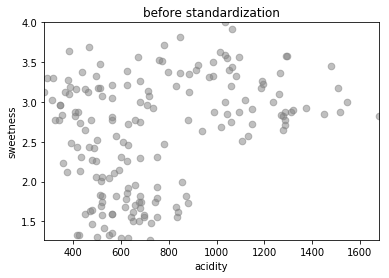

In [44]:
col1 = columns[0]
col2 = columns[1]
plt.scatter(df[col1], df[col2], s=44, c='#808080', alpha=0.5)
plt.xlim(df[col1].min(), df[col1].max())
plt.ylim(df[col2].min(), df[col2].max())
plt.title('before standardization')
plt.xlabel(col1)
plt.ylabel(col2)
plt.show()

[[-0.08246584 -1.88166245]
 [-0.46529841 -1.85349456]
 [-0.36959027 -1.85349456]
 [-0.78432556 -1.83941061]
 [-1.05549863 -1.79715877]
 [-1.02359591 -1.79715877]
 [-0.62481199 -1.79715877]
 [-0.59290927 -1.75490693]
 [-0.68861741 -1.67040325]
 [-0.84813099 -1.59998352]]
<type 'numpy.ndarray'>
    acidity  sweetness
0 -0.082466  -1.881662
1 -0.465298  -1.853495
2 -0.369590  -1.853495
3 -0.784326  -1.839411
4 -1.055499  -1.797159
(179, 2)


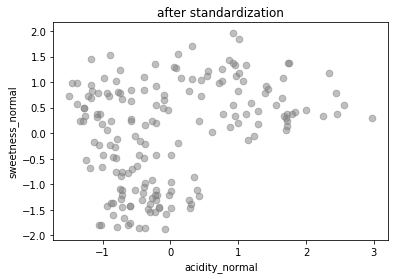

In [45]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

col1 = 'acidity_normal'
col2 = 'sweetness_normal'
#df['sweetness_normal'] = (df.sweetness - df.sweetness.mean()) / df.sweetness.std()
#df['acidity_normal'] = (df.acidity - df.acidity.mean()) / df.acidity.std()

df2 = df.loc[:,['acidity', 'sweetness']]
np_normal = sc.fit_transform(df2)
print(np_normal[:10])
print(type(np_normal))

df_normal = pd.DataFrame(np_normal, columns=['acidity', 'sweetness'])
print(df_normal.head())
print(df_normal.shape)

#plt.scatter(df[col1], df[col2], s=44, c='#808080', alpha=0.5)
#plt.xlim(df[col1].min(), df[col1].max())
#plt.ylim(df[col2].min(), df[col2].max())

plt.scatter(df_normal.acidity, df_normal.sweetness, s=44, c='#808080', alpha=0.5)
plt.title('after standardization')
plt.xlabel(col1)
plt.ylabel(col2)
plt.show()

Make a numpy array of the (x, y) values of the above ``sweetness_normal`` and ``acidity_normal`` features

In [46]:
#data = np.array([list(df[col1]), list(df[col2])]).T # a 179 x 2 array of instances x features
data = np.array([list(df_normal.acidity), list(df_normal.sweetness)]).T # a 179 x 2 array of instances x features
data.shape

(179, 2)

#### 3. Showing the steps of k-means centroid convergence #

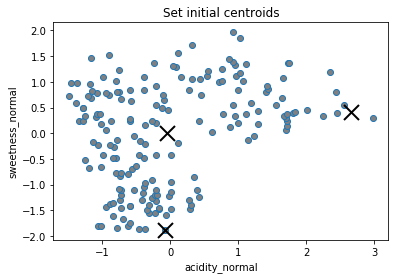

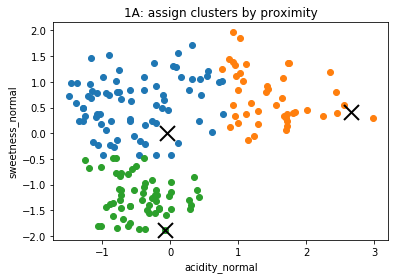

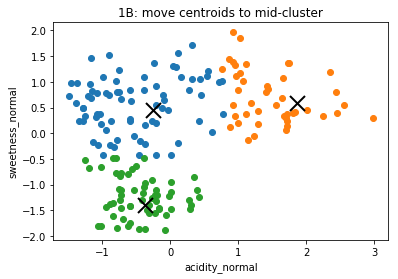

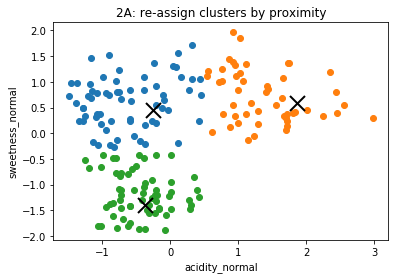

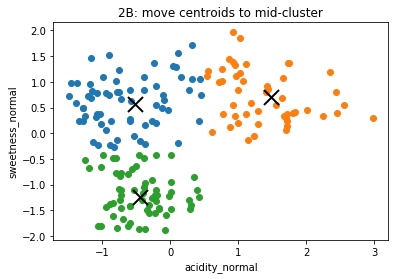

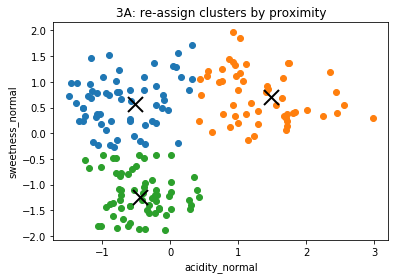

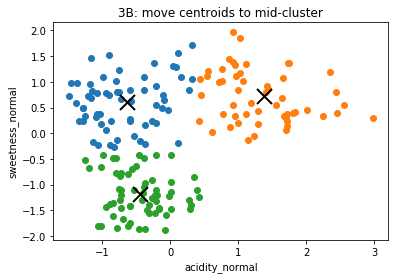

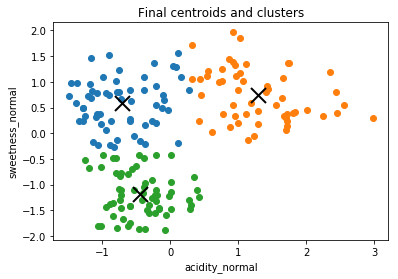

In [47]:
k = 3 #number of clusters

start= np.array([[ 1 , 0], [ 2, -1], [ 2, -2] ]) # starting points for the clusters

steps = ['Set initial centroids',
         '1A: assign clusters by proximity',
         '1B: move centroids to mid-cluster',
         '2A: re-assign clusters by proximity',
         '2B: move centroids to mid-cluster',
         '3A: re-assign clusters by proximity',
         '3B: move centroids to mid-cluster',
         'Final centroids and clusters']

centroids = []

for i, stepname in enumerate(steps):

    num_iterations = [1, 2, 2, 3, 3, 4, 4, 100][i]
    kmeans = cluster.KMeans(n_clusters=k, max_iter=num_iterations, init=start, n_init=1)
    kmeans.fit(data)
    labels = kmeans.labels_
    centroids.append(kmeans.cluster_centers_)
    
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.title(stepname)

    if i == 0:
        #plot every point in grey
        plt.plot(data[:,0],data[:,1],'o',markerfacecolor='#808080')
        for j in range(k):
            lines = plt.plot(centroids[i][j,0],centroids[i][j,1],'kx')
        # make the centroid x's bigger
            plt.setp(lines,ms=15.0)
            plt.setp(lines,mew=2.0)
    else: 
        # plot every label in a different color
        for j in range(k):
            subset = data[np.where(labels==j)]
            plt.plot(subset[:,0],subset[:,1],'o')
            # plot the centroids
            if i in [1,3,5]:
                # from previous step
                lines = plt.plot(centroids[i-1][j,0],centroids[i-1][j,1],'kx')
            else:
                lines = plt.plot(centroids[i][j,0],centroids[i][j,1],'kx')
            # make the centroid x's bigger
            plt.setp(lines,ms=15.0)
            plt.setp(lines,mew=2.0)

    plt.show()
    

#### 4. Evaluate the reproducibility of k-means clustering this dataset #

Since the final K-Means clusters can be dependent on the initial centroid positions chosen (usually randomly), let's run the algorithm 100 times and find out how often instances are assigned to different clusters. (Ironically, with K-Means clustering, the most inconsistent results can occur in datasets that exhibit the best clustering. This should not be an issue with our data, but it's best to be sure.)

First we make a 179x100 numpy array to hold the cluster assignments ('labels'): 0, 1 or 2 (since we have predetermined there are three clusters).

In [48]:
for i in range(100):
    kmeans = cluster.KMeans(n_clusters=3, max_iter=100, init='random', n_init=1)
    kmeans.fit(data)
    labels = np.array(kmeans.labels_)
    if i==0:
        all_labels = labels
    else:
        all_labels = np.vstack((all_labels, labels))

Since the numbers of the clusters (0, 1 or 2) are not consistent from run to run, we will choose three datapoints that are representative of the clusters. Going through the data, I chose points 10, 144 and 160 in the lower left, upper left, and upper right, respectively.

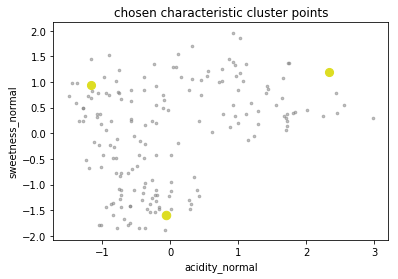

In [49]:
#plt.scatter(df[col1], df[col2], s=7, c='#808080', alpha=0.5)
#plt.scatter(data[10,0], data[10,1], s=72, c='#dddd22')
#plt.scatter(data[144,0], data[144,1], s=66, c='#dddd22')
#plt.scatter(data[160,0], data[160,1], s=66, c='#dddd22')
#plt.xlim(df[col1].min(), df[col1].max())
#plt.ylim(df[col2].min(), df[col2].max())

plt.scatter(df_normal.acidity, df_normal.sweetness, s=7, c='#808080', alpha=0.5)
plt.scatter(data[10,0], data[10,1], s=72, c='#dddd22')
plt.scatter(data[144,0], data[144,1], s=66, c='#dddd22')
plt.scatter(data[160,0], data[160,1], s=66, c='#dddd22')
plt.title('chosen characteristic cluster points')
plt.xlabel(col1)
plt.ylabel(col2)
plt.show()

Go through each repetition and assign each point to the cluster that each of the above three points represents, then find any points whose cluster assignment has a nonzero standard deviation.

In [50]:
regularized_labels = np.zeros(all_labels.shape, dtype=np.int8)
disagreements = []

for i in range(all_labels.shape[0]):
    cluster0 = all_labels[i, 10]
    cluster1 = all_labels[i, 144]
    cluster2 = all_labels[i, 160]
    for j in range(all_labels.shape[1]):
        if all_labels[i,j] == cluster1:
            regularized_labels[i,j] = 1
        elif all_labels[i,j] == cluster2:
            regularized_labels[i,j] = 2
        
for i in range(regularized_labels.shape[1]):
    disagreements.append(regularized_labels[:,i].std()) # standard deviations

Visualize all the points that are ever assigned to two different clusters.

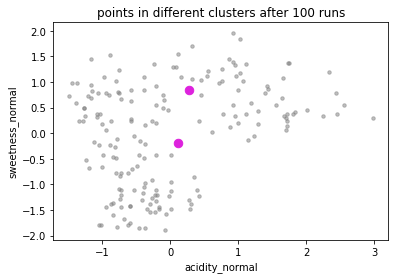

In [51]:
#plt.scatter(df[col1], df[col2], s=12, c='#808080', alpha=0.5)
plt.scatter(df_normal.acidity, df_normal.sweetness, s=12, c='#808080', alpha=0.5)
for i in range(len(disagreements)):
    if disagreements[i] > 0:
        plt.scatter(data[i,0], data[i,1], s=72, c='#dd22dd')
#plt.xlim(df[col1].min(), df[col1].max())
#plt.ylim(df[col2].min(), df[col2].max())
plt.title('points in different clusters after 100 runs')
plt.xlabel(col1)
plt.ylabel(col2)
plt.show()

#### 5. Cluster with different values of k #

What does the clustering look like with 2, 3, 4 or 5 clusters?

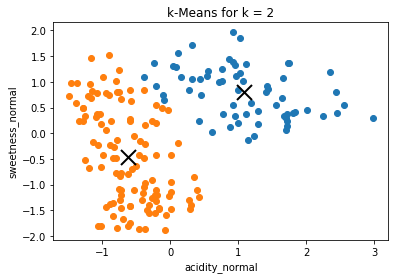

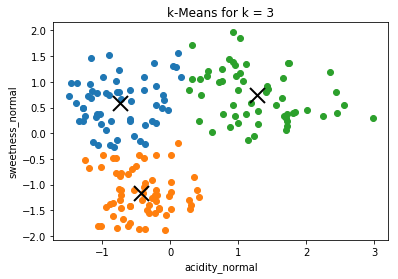

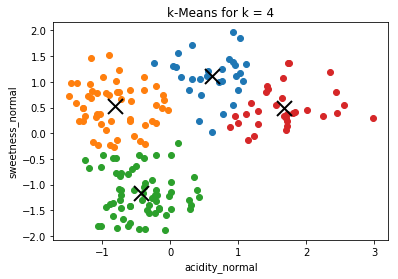

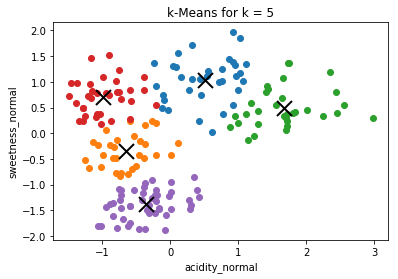

In [52]:
# comparison of different values of k
def compare_kmeans(k):
    
    kmeans = cluster.KMeans(n_clusters=k)
    kmeans.fit(data)

    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_

    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.title('k-Means for k = ' + str(k))

    for i in range(k):
        subset = data[np.where(labels==i)]
        plt.plot(subset[:,0],subset[:,1],'o')
        # plot the centroids
        lines = plt.plot(centroids[i,0],centroids[i,1],'kx')
        # make the centroid x's bigger
        plt.setp(lines,ms=15.0)
        plt.setp(lines,mew=2.0)
    plt.show()
    
compare_kmeans(2)
compare_kmeans(3)
compare_kmeans(4)
compare_kmeans(5)

#### Find the maximum silhouette coefficient #

The silhouette coefficient compares inter- and intra-cluster distances to find the value of k that best separates the points into clusters.

(1, 10)

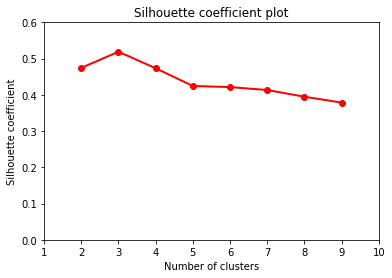

In [53]:
from sklearn.metrics import silhouette_score

def kmeans_silhouette(k):
    kmeans = cluster.KMeans(n_clusters=k)
    kmeans.fit(data)
    labels = kmeans.labels_
    score = silhouette_score(data, labels)
    return score

silhouettes = []
for i in range(2,10):
    silhouettes.append(kmeans_silhouette(i))

plt.plot(range(2,10), silhouettes, 'ro-', lw=2)
plt.title('Silhouette coefficient plot')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette coefficient')
plt.ylim(0, 0.6)
plt.xlim(1,10)